In [327]:
import sys
import sql
import pandas as pd
from functools import reduce
from tabulate import tabulate
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import common
import numpy as np

In [328]:
q = '''select *
from fix_commits fc
join fixing_releases fr on fc.advisory_id = fr.advisory_id
where commit_date is not null
and version!=%s;'''
df = pd.DataFrame(sql.execute(q,(common.manualcheckup)))
df['advisory_id'].nunique()

2497

In [329]:
#not present in Maven central repository
q='''select *
from fix_commits fc
join fixing_releases fr on fc.advisory_id = fr.advisory_id
join package p on fc.package_id = p.id
where commit_date is not null
and version!=%s
and fc.advisory_id not in
(select advisory_id
from fixing_releases fr
join advisory a on fr.advisory_id = a.id
join release_info ri on fr.version = ri.version and ri.package_id=a.package_id);'''
df = pd.DataFrame(sql.execute(q,(common.manualcheckup)))
df['package_id'].nunique(), df['advisory_id'].nunique()

(75, 145)

In [330]:
q='''select *
from fix_commits fc
join fixing_releases fr on fc.advisory_id = fr.advisory_id
join package p on fc.package_id = p.id
join release_info ri on p.id = ri.package_id and ri.version=fr.version
where commit_date is not null
and fr.version!='manual checkup needed'
and ri.publish_date is null;'''
df = pd.DataFrame(sql.execute(q))
df['package_id'].nunique(), df['advisory_id'].nunique(), df['ri.id'].nunique()

(272, 341, 357)

In [331]:
q = '''select advisory_id, package_id, ecosystem, type, severity, disclose_date, publish_date,
        fix_commit_date, release_date, version, concat('package', package_id, 'version', version) as fixing_release
        from
        (select advisory_id, min(commit_date) as fix_commit_date
        from fix_commits fc
        join package p on fc.package_id = p.id
        where commit_date is not null
        group by advisory_id) as fcd
        join
        (select a.*, p.ecosystem, ri.version, ri.publish_date as release_date
        from advisory a
        join package p on a.package_id = p.id
        join fixing_releases fr on a.id = fr.advisory_id
        join release_info ri on p.id = ri.package_id and ri.version=fr.version
        where type != 'Malicious Package'
        and fr.version!= 'manual checkup needed'
            and ri.publish_date is not null) as frd
        on fcd.advisory_id=frd.id;'''
df = pd.DataFrame(sql.execute(q))
df['fix_to_release_delay'] = (df['release_date'] - df['fix_commit_date']).dt.total_seconds()
df['fix_to_release_delay'] = round ( df['fix_to_release_delay'] / (3600 * 24))
df['disclose_to_fix_delay'] = (df['fix_commit_date'].dt.date - df['disclose_date']).dt.days
df['release_to_publish_delay'] = (df['publish_date'] - df['release_date'].dt.date).dt.days
df['fix_to_publish_delay'] = (df['publish_date'] - df['fix_commit_date'].dt.date).dt.days
df

,advisory_id,package_id,ecosystem,type,severity,disclose_date,publish_date,fix_commit_date,release_date,version,fixing_release,fix_to_release_delay,disclose_to_fix_delay,release_to_publish_delay,fix_to_publish_delay
0,SNYK-PYTHON-SALT-174927,1,pip,Arbitrary Code Execution,H,2013-05-11,2019-06-06,2013-09-19 18:27:38,2013-10-17 18:17:40,0.17.1,package1version0.17.1,28.0,131,2058,2086
1,SNYK-PYTHON-SALT-40687,1,pip,Denial of Service (DoS),H,2017-08-24,2017-11-05,2017-08-31 17:07:42,2017-10-09 16:33:50,2016.11.8,package1version2016.11.8,39.0,7,27,66
2,SNYK-PYTHON-SALT-40687,1,pip,Denial of Service (DoS),H,2017-08-24,2017-11-05,2017-08-31 17:07:42,2017-10-09 16:30:36,2016.3.8,package1version2016.3.8,39.0,7,27,66
3,SNYK-PYTHON-SALT-40687,1,pip,Denial of Service (DoS),H,2017-08-24,2017-11-05,2017-08-31 17:07:42,2017-10-09 16:39:22,2017.7.2,package1version2017.7.2,39.0,7,27,66
4,SNYK-PYTHON-SALT-40688,1,pip,Directory Traversal,H,2017-08-23,2017-11-05,2017-08-31 17:06:33,2017-10-09 16:33:50,2016.11.8,package1version2016.11.8,39.0,8,27,66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2784,SNYK-JS-APOLLOGATEWAY-174915,1852,npm,Prototype Pollution,H,2019-06-04,2019-06-05,2019-06-04 23:23:04,2019-06-04 23:25:34,0.6.2,package1852version0.6.2,0.0,0,1,1
2785,SNYK-PHP-LIGHTSAMLLIGHTSAML-72139,2335,Composer,Access Restriction Bypass,H,2018-04-18,2018-04-26,2018-03-05 16:26:57,2018-03-05 16:29:08,1.3.5,package2335version1.3.5,0.0,-44,52,52
2786,SNYK-PHP-TYPO3CMS-73594,272,Composer,Security Misconfiguration,H,2019-01-22,2019-01-22,2019-01-22 08:42:56,2019-01-22 10:10:02,8.7.23,package272version8.7.23,0.0,0,0,0
2787,SNYK-PHP-TYPO3CMS-73594,272,Composer,Security Misconfiguration,H,2019-01-22,2019-01-22,2019-01-22 08:42:56,2019-01-22 10:12:04,9.5.4,package272version9.5.4,0.0,0,0,0


In [332]:
df['advisory_id'].nunique()

2068

In [333]:
total = len(df)
d2f = df[df['disclose_to_fix_delay'] > 0]
before = len(d2f)
d2f['disclose_to_fix_delay'].describe(), before/total


(count     708.000000
 mean       70.515537
 std       184.361411
 min         1.000000
 25%         1.000000
 50%         7.000000
 75%        38.000000
 max      1849.000000
 Name: disclose_to_fix_delay, dtype: float64,
 0.25385442811043385)

In [334]:
df['release_to_publish_delay'].describe()

count    2789.000000
mean      178.426318
std       464.064366
min     -1756.000000
25%         1.000000
50%        11.000000
75%       132.000000
max      4918.000000
Name: release_to_publish_delay, dtype: float64

In [335]:
wrong = df[df['fix_to_release_delay'] < 0]
wrong = wrong.sample(frac=1).reset_index(drop=True)
wrong.to_csv('delaylessthanzero.csv', index=False)

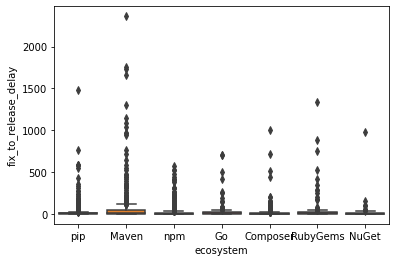

In [336]:
df= df[df['fix_to_release_delay'] >= 0]
ax = sns.boxplot(y='fix_to_release_delay', x='ecosystem', data = df)
plt.savefig('fix_to_release_delay.png')

In [337]:
gb = df.groupby('ecosystem')
eco_dfs = [(x,gb.get_group(x)) for x in gb.groups]
adv = df.groupby('ecosystem')[['advisory_id']].nunique()
pkg = df.groupby('ecosystem')[['package_id']].nunique()
rel = df.groupby('ecosystem')['fixing_release'].nunique()
fixrel = df.groupby('ecosystem')[['fix_to_release_delay']].median()
pub_before_release = df[df['release_to_publish_delay']<0]
pub_before_release = pub_before_release.groupby('ecosystem')[['advisory_id']].count()
pub_before_fix = df[df['fix_to_publish_delay']<0]
pub_before_fix = pub_before_fix.groupby('ecosystem')[['advisory_id']].count()
rel

ecosystem
Composer    204
Go          224
Maven       745
NuGet        52
RubyGems    121
npm         586
pip         308
Name: fixing_release, dtype: int64

In [338]:
final =reduce(lambda x,y : pd.merge(x,y,on='ecosystem'),[adv, pkg, rel, fixrel,pub_before_release, pub_before_fix])
final = final.reset_index()
final.columns = ['ecosystem','advisory','package','releases','fix_to_release', 'publish_before_release','publish_before_fix']
final['publish_before_release'] =  round(final['publish_before_release'] / final['releases'] * 100, 1)
final['publish_before_fix'] =  round(final['publish_before_fix'] / final['releases'] * 100, 1)
final['temp'] = final['ecosystem'].str.lower()
final = final.sort_values(by = 'temp', ascending=True)
final = final.drop('temp', axis=1)
final

,ecosystem,advisory,package,releases,fix_to_release,publish_before_release,publish_before_fix
0,Composer,183,93,204,1.0,12.3,5.4
1,Go,184,150,224,7.0,21.4,8.9
2,Maven,574,385,745,16.0,21.1,4.0
5,npm,553,412,586,1.0,25.1,9.7
3,NuGet,70,22,52,4.0,9.6,7.7
6,pip,324,200,308,6.0,27.6,14.0
4,RubyGems,113,80,121,7.0,8.3,3.3


In [339]:
print(tabulate(final, tablefmt='latex', headers='keys',showindex=False))

\begin{tabular}{lrrrrrr}
\hline
 ecosystem   &   advisory &   package &   releases &   fix\_to\_release &   publish\_before\_release &   publish\_before\_fix \\
\hline
 Composer    &        183 &        93 &        204 &                1 &                     12.3 &                  5.4 \\
 Go          &        184 &       150 &        224 &                7 &                     21.4 &                  8.9 \\
 Maven       &        574 &       385 &        745 &               16 &                     21.1 &                  4   \\
 npm         &        553 &       412 &        586 &                1 &                     25.1 &                  9.7 \\
 NuGet       &         70 &        22 &         52 &                4 &                      9.6 &                  7.7 \\
 pip         &        324 &       200 &        308 &                6 &                     27.6 &                 14   \\
 RubyGems    &        113 &        80 &        121 &                7 &                      8

In [340]:
# q='select * from fix_commits where commit_date is not null'
# df = pd.DataFrame(sql.execute(q))
# df['auth_commit_delay'] = (df['commit_date'].dt.date - df['author_date'].dt.date).dt.days
# df['auth_commit_delay'].describe()
# print(len(df))
# df = df[df['auth_commit_delay'] > 0]
# len(df)

In [341]:
high, medium, low = df[df['severity']=='H'], df[df['severity']=='M'], df[df['severity']=='L']
high['fix_to_release_delay'].describe(), medium['fix_to_release_delay'].describe(), low['fix_to_release_delay'].describe()

(count    1163.000000
 mean       34.128977
 std       109.367414
 min         0.000000
 25%         0.000000
 50%         6.000000
 75%        22.000000
 max      1758.000000
 Name: fix_to_release_delay, dtype: float64,
 count    1348.000000
 mean       39.817507
 std       127.074796
 min         0.000000
 25%         0.000000
 50%         6.000000
 75%        28.250000
 max      1734.000000
 Name: fix_to_release_delay, dtype: float64,
 count     129.000000
 mean       51.635659
 std       250.196733
 min         0.000000
 25%         0.000000
 50%         3.000000
 75%        14.000000
 max      2363.000000
 Name: fix_to_release_delay, dtype: float64)

In [342]:

from scipy.stats import mannwhitneyu
mannwhitneyu(high['fix_to_release_delay'],medium['fix_to_release_delay']), mannwhitneyu(high['fix_to_release_delay'],low['fix_to_release_delay']), mannwhitneyu(medium['fix_to_release_delay'],low['fix_to_release_delay'])

(MannwhitneyuResult(statistic=760928.0, pvalue=0.10010332931359212),
 MannwhitneyuResult(statistic=72403.0, pvalue=0.2555501270427748),
 MannwhitneyuResult(statistic=81135.0, pvalue=0.10212063588618164))

In [343]:
q = '''select advisory_id, package_id, ecosystem, min(release_date) as first,
       max(release_date) as last
        from
        (select advisory_id, min(commit_date) as fix_commit_date
        from fix_commits fc
        join package p on fc.package_id = p.id
        where ecosystem = 'npm'
        and commit_date is not null
        group by advisory_id) as fcd
        join
        (select a.*, p.ecosystem, ri.version, ri.publish_date as release_date
        from advisory a
        join package p on a.package_id = p.id
        join fixing_releases fr on a.id = fr.advisory_id
        join release_info ri on p.id = ri.package_id and ri.version=fr.version
        where ecosystem = 'npm'
        and type != 'Malicious Package'
        and fr.version!= 'manual checkup needed'
            and ri.publish_date is not null) as frd
        on fcd.advisory_id=frd.id
            and fcd.advisory_id in
    (select advisory_id from
(select advisory_id, count(*)
from
(select advisory_id, min(commit_date) as fix_commit_date
from fix_commits fc
join package p on fc.package_id = p.id
where ecosystem = 'npm'
and commit_date is not null
group by advisory_id) as fcd
join
(select a.*, p.ecosystem, ri.version, ri.publish_date as release_date
from advisory a
join package p on a.package_id = p.id
join fixing_releases fr on a.id = fr.advisory_id
join release_info ri on p.id = ri.package_id and ri.version=fr.version
where ecosystem = 'npm'
and type != 'Malicious Package'
and fr.version!= 'manual checkup needed'
    and ri.publish_date is not null) as frd
on fcd.advisory_id=frd.id
group by advisory_id
having count(*) > 1) as sub) 
group by advisory_id, package_id, ecosystem;'''
multiple_rel = pd.DataFrame(sql.execute(q))
multiple_rel['range'] = (multiple_rel['last'].dt.date - multiple_rel['first'].dt.date).dt.days
multiple_rel['range'].describe()

count      57.000000
mean       41.508772
std       156.849350
min         0.000000
25%         0.000000
50%         4.000000
75%         9.000000
max      1130.000000
Name: range, dtype: float64

In [344]:
q='''select id as advisory_id,
       case
        when id in (select advisory_id from advisoryCVE) then 'cve'
        else 'noncve'
end as ifcve
from advisory;'''
ifcve = pd.DataFrame(sql.execute(q))
print(len(df), len(ifcve))
df= pd.merge(df, ifcve, on='advisory_id')
len(df)

2640 6956


2640

In [345]:
cve = df[df['ifcve']=='cve']
noncve = df[df['ifcve']=='noncve']
print(len(cve), len(noncve))

2005 635


In [346]:
cve['fix_to_release_delay'].describe(), noncve['fix_to_release_delay'].describe()

(count    2005.000000
 mean       31.808479
 std       117.267072
 min         0.000000
 25%         0.000000
 50%         6.000000
 75%        23.000000
 max      2363.000000
 Name: fix_to_release_delay, dtype: float64,
 count     635.000000
 mean       57.088189
 std       158.075996
 min         0.000000
 25%         0.000000
 50%         6.000000
 75%        36.000000
 max      1341.000000
 Name: fix_to_release_delay, dtype: float64)

In [347]:
mannwhitneyu(cve['fix_to_release_delay'],noncve['fix_to_release_delay'].describe())

MannwhitneyuResult(statistic=5073.0, pvalue=0.03477827223692795)